# Построение скоринговой модели бинарной классифкации по данным Home credit bank

План работы для анализа только данные application
1. Смотрим на признаки в целом (типы, размер и пропущенные значения)
2. Исследуем признаки по отдельности, заполняя пропуска и может быть создавая новые для количественных
3. Исследуем признаки на коллиниарность, отмечая те, которые сильно зависимые, потом может сплющим, если поможет
4. Кодируем категориальныех признаки (если надумаем не бустинг)
5. Убираем таргет, загоняем в модель LGBM, фитим
6. Проверяем на метриках
7. Смотрим на самые важные

## 1 ЗАГРУЗКА И ОБЩИЙ АНАЛИЗ

In [1]:
# загрузим базовые библиотеки для начала
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from lightgbm import LGBMClassifier
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, roc_auc_score
import shap

In [ ]:
df_train = pd.read_csv(r'C:\Users\user\Desktop\HCB\application_train.csv')
df_test = pd.read_csv(r'C:\Users\user\Desktop\HCB\application_test.csv')

Смотрим на тренирочные данные

In [ ]:
df_train.head()

In [ ]:
df_train.info()

In [ ]:
df_train.describe()

122 признака, 16 категориальных, таргет включена, бинарная классификация, может быть логистичекая регрессия тоже подойдет?

In [ ]:
df_train.select_dtypes(include=[object]).apply(pd.Series.unique, axis = 0)

Категориальные поля можно будет закодировать, но это очень сильно замедлит модель, поэтому попробуем просто LGBM

In [ ]:
df_test.head()

в тестовой выборке 121 поле, без таргета

Посмотрим на пропуски в целом по дата фрейму

In [ ]:
sns.heatmap(df_train.isnull(), cmap = 'summer').set(title='Диаграмма 1 Пропущеные значения')

In [ ]:
miss_total = df_train.isnull().sum()

In [ ]:
miss_per = 100 * miss_total/len(df_train)
miss_per.value_counts(ascending = False)

По многим полям порядка 70% незаполненных значений - мы ничего не будем пока делать, чтобы не внести дополнительный вес фичей, которые в реальности не имеют отношения к определению целевой метрики, единственное - надо посмотреть, совпадают ли пропуски в тесте с train - **но как?**

Посмотрим есть ли дисбаланс классов в таргете

In [ ]:
df_train['TARGET'].value_counts(normalize=True)

In [ ]:
sns.histplot(df_train['TARGET'], color = "blue").set(title = 'Диаграмма 2 Распределение таргета')

Очевидный дисбаланс, порядка 92% приходится на 0 - без дефолта, возвращают кредит. Дисбаланс не всегда есть хорошо - **как задел для повышения качества модели**

## 2. Исследование признаков

Полей очень много, все исследовать не получиться, нужно определить какие фичи наиболее всего зависят от таргета, и уже их непосредственно исследовать

In [ ]:
corr_features = df_train.corr()['TARGET'].sort_values()
corr_features

Корреляции нам показывает на признаки, которые стоит анализировать прежде всего:
Наибольшая положительная корреляция (возьмем первые 5):
- DAYS_BIRTH возраст
- REGION_RATING_CLIENT_W_CITY - рейтинг клиента в городе
- REGION_RATING_CLIENT - рейтинг клиента в регионе
- DAYS_LAST_PHONE_CHANGE - дата последнего смена телефона
- DAYS_ID_PUBLISH - публикация ID (?)
Наибольшая отрицательная корреляция (возьмем первые 3): непонятно пока что это такое
- EXT_SOURCE_3
- EXT_SOURCE_2
- EXT_SOURCE_1

### 2.1 Исследуем признаки с отрицательной корреляцией

In [ ]:
plt.rcParams['figure.figsize'] = (20,6)
df_train['EXT_SOURCE_3'].hist(bins=100)
plt.title('Диаграмма Распределение признака EXT_SOURCE_3')

In [ ]:
plt.rcParams['figure.figsize'] = (20,6)
df_train['EXT_SOURCE_2'].hist(bins=100)
plt.title('Диаграмма Распределения признака EXT_SOURCE_2')

In [ ]:
plt.rcParams['figure.figsize'] = (20,6)
df_train['EXT_SOURCE_1'].hist(bins=100)
plt.title('Диаграмма Распределения признака EXT_SOURCE_2')

посмотрим в разрезе таргета

In [ ]:
plt.figure(figsize = (10, 12))
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # создаем график для каждой фичи
    plt.subplot(3, 1, i + 1)
    # займы которые вернули
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target == 0') # не вывел название таргета
    # займы которые не вернули
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target == 1')
    # Названия графиков
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 3)

распределение абсолютно разное по классам, посмотрим на матрицу корреляции через heatmap

In [ ]:
sns.heatmap(df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].corr(), cmap="YlGnBu", annot = True).set(title = 'матрица корреляции 1')

Ну вот видим, что этим признаки положительно коррелируют с собой, не критично конечно, но запомним это.
Посмотрим как все выбранные признаки (8 ед) коррелируют между собой.

In [ ]:
sns.heatmap(df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH']].corr(), cmap = "Blues", annot = True).set(title = 'матрица корреляции 1')

Так так,рейтинг региона очень сильно коррелирует с рейтингом клиента в городе, а DAYS_BIRTH имеют сильную обратную корреляцию с EXT_SOURCE_1, вот только что это такое EXT_SOURCE_1? в остальном все нормально вроде.

### 2.2 Исследуем признаки с положительной корреляцией

In [ ]:
plt.figure(figsize = (10, 12))
for i, source in enumerate(['DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT','DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH']):

    # создаем график для каждой фичи
    plt.subplot(5, 1, i + 1)
    # займы которые вернули
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target == 0') # не вывел название таргета
    # займы которые не вернули
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target == 1')
    # Названия графиков
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 3)

По данным графикам видно, что распределение фичи в зависимости от таргета более-менее равномерное

**Возраст**

In [ ]:
df_train['DAYS_BIRTH'].head()

In [ ]:
df_train['DAYS_BIRTH'] = abs(df_train['DAYS_BIRTH']/365)

In [ ]:
df_train['DAYS_BIRTH'].head()

In [ ]:
df_train['DAYS_BIRTH'].corr(df_train['TARGET'])

Так понимаю это возраст заемщиков, перевели из отрицательных дней в года, перезаписали, корреляция сменила знак, но это не критично, потому как логика осталась - отрицательно коррелирует с невозвратом, т.е. чем выше возраст, тем ниже невозврат

**рейтинг клиента в городе**

In [ ]:
df_train['REGION_RATING_CLIENT_W_CITY'].head()

In [ ]:
df_train['REGION_RATING_CLIENT_W_CITY'].value_counts(normalize=True)

**рейтинг клиента в регионе**
тут такая же картина, неудивительно почему они коррелируют

In [ ]:
df_train['REGION_RATING_CLIENT'].value_counts(normalize=True)

**дата последнего смена телефона**

In [ ]:
df_train['DAYS_LAST_PHONE_CHANGE'].head()

In [ ]:
df_train['DAYS_LAST_PHONE_CHANGE'] = abs(df_train['DAYS_LAST_PHONE_CHANGE']/365)
df_train['DAYS_LAST_PHONE_CHANGE'].head()

In [ ]:
df_train['DAYS_LAST_PHONE_CHANGE'].sort_values(ascending=False)

**DAYS_ID_PUBLISH**

In [ ]:
df_train['DAYS_ID_PUBLISH'].head()

In [ ]:
df_train['DAYS_ID_PUBLISH'] = abs(df_train['DAYS_ID_PUBLISH']/365)
df_train['DAYS_ID_PUBLISH'].head()

не особо заметны выбросы, но график явно не традиционной ориентации

## 3. Отправляем в модель

In [ ]:
# уберем таргет из тренировочной выборки, категориальные фичи он должен съесть
target = df_train['TARGET']
train = df_train.drop(labels= ['TARGET'], axis = 1)

In [ ]:
train.head()

In [ ]:
test = df_test
test.head()

In [ ]:
train, test = train.align(train, join = 'inner', axis = 1)

print('Тренировочная выборка', train.shape)
print('Тестовая выборка', test.shape)

In [ ]:
cat = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

In [ ]:
for c in cat:
    train[c] = train[c].astype('category')

In [ ]:
model = LGBMClassifier(objective="binary")
model.fit(train, target, categorical_feature=cat)

In [ ]:
for c in cat:
    test[c] = test[c].astype('category')

In [ ]:
predict = model.predict_proba(test)[:, 1]

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
metrics = roc_auc_score(target, predict)
print('LightGBM: ROC AUC=%.3f' % (metrics))


In [ ]:
print(train.dtypes)

In [ ]:
train_2 = train.copy()

In [ ]:

#explainer = shap.Explainer(model)
#shap_values = explainer(train)

#shap.plots.beeswarm(shap_values)
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train)
shap.summary_plot(shap_values, train)

Модель определила признаки, которые дают сильный вклад в предсказание, которые мы не стали анализировать, например AMT_GOOD_Price,

Добавляем бюро

In [ ]:
bureau = pd.read_csv('bureau.csv')
bureau

In [ ]:
sns.heatmap(bureau.isnull(), cmap = 'summer').set(title='Диаграмма Пропущеные значения')

In [ ]:
bureau.head()

попробуем привести к нужному типу данных

In [ ]:
print(bureau.dtypes)

In [ ]:
cat_b = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
for c in cat_b:
    bureau[c] = bureau[c].astype('category')
print(bureau.dtypes)

In [ ]:
df_gr = bureau.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].agg(['max','mean','min'])
df_gr.head()

In [ ]:
train_1 = train.merge(right=df_gr.reset_index(), how='left', on='SK_ID_CURR')
test_1 = test.merge(right=df_gr.reset_index(), how='left', on='SK_ID_CURR')

In [ ]:
train_1, test_1 = train_1.align(train_1, join='inner', axis=1)

In [ ]:
model_1 = LGBMClassifier(objective="binary")
model_1.fit(train_1, target, categorical_feature=cat)

In [ ]:
test_1.info()

In [ ]:
predict_1 = model_1.predict_proba(test_1)[:,1]

In [ ]:
predict_1

In [ ]:
metrics_1 = roc_auc_score(target, predict_1)

In [ ]:
print('LightGBM: ROC AUC=%.3f' % (metrics_1))

Добавляем другие таблицы и делаем все

In [ ]:
bur_balance = pd.read_csv(r'C:\Users\user\Desktop\HCB\bureau_balance.csv')
credit_card = pd.read_csv(r'C:\Users\user\Desktop\HCB\credit_card_balance.csv')
instal_pay = pd.read_csv(r'C:\Users\user\Desktop\HCB\installments_payments.csv')
Posh_card = pd.read_csv(r'C:\Users\user\Desktop\HCB\POS_CASH_balance.csv')

### Задача повысить скор на основе генеранции новых фич
ДАНО:
* дефолтный сет скор составляет AUC 0,799
* сет с бюро составляет AUC 0,802
Посмострим дополнительно какие фичи можно нагенерить в обоих случаях для увеличения предсказательной силы

In [ ]:
dt_new = df_train.copy()
dt_new.head()

#### Посмотрим описание колонок в целом, нас интересует численные столбцы

In [ ]:
description = pd.read_csv(r'C:\Users\user\Desktop\HCB\HomeCredit_columns_description.csv', encoding="ISO-8859-1")
description

В базовом датасете:
AMT_INCOME_TOTAL - общий доход
AMT_CREDIT - сумма кредита
AMT_ANNUITY - сумма платежа по кредиту
AMT_GOODS_PRICE - цена товара, на который одобрили кредит

По остальным колонкам много пропусков, весьма ненадежно из них получать новые данные

Попробуем синтезировать числовые фичи и добавить их в основной датасет. Одной из важных характеристик является кредитная ставка, поскольку она закладывается с учетом риск. Ее нет в дата сете и ее не вывести, можно принять условно, что соотношение платежа по кредиту к общей кредитной сумме условно может отражать ставку риска. Также на дефолт может влиять соотношение общего дохода и суммы кредита. Платеж по кредиту, если он автоматический, зачастую зависит от уровня доходов, но ставка для высокорискованных заемщиков как правило выше. Общий стаж работы тоже влияет (допустим банк одобряет клиентам старше 22, но у каждого может быть свой трудовой стаж).

Бездумно генерить кучу соотношений мне представляется нецелесообразным, новые фичи должны быть как минимум интерпретированы для заказчика, например общий доход/количество отработанных дней - это не стоимость трудо-дня за всю историю, а просто текущий доход на общий стаж - т.е. кривая метрика


Посмотрим пропуска в колонках

In [ ]:
dt_new['AMT_INCOME_TOTAL'].isnull().sum()

In [ ]:
dt_new['AMT_CREDIT'].isnull().sum()

In [ ]:
dt_new['AMT_ANNUITY'].isnull().sum()

In [ ]:
dt_new['AMT_GOODS_PRICE'].isnull().sum()

In [ ]:
diff = dt_new['AMT_CREDIT'] - dt_new['AMT_GOODS_PRICE']
diff

Фича цена - является фактически эквивалентом выданного кредита, так как там много пропусков - делать с ней ничего не будем, если посчитать разницу там, где пропуски будут значения - внесет просто шум в данные. Строки по аннуитету, где есть пропуски всего 12 - это не критично.

## генерим новые фичи

1. Условная процентная ставка (платеж по кредиту/сумму кредита)

In [ ]:
dt_new['CREDIT_PERCENT'] = dt_new['AMT_ANNUITY'] / dt_new['AMT_CREDIT']

2. Соотношение платеж к ЗП

In [ ]:
dt_new['ANNUITY_INCOME'] = dt_new['AMT_ANNUITY'] / dt_new['AMT_INCOME_TOTAL']

3. Соотношение величины кредита к ЗП

In [ ]:
dt_new['CREDIT_INCOME'] = dt_new['AMT_CREDIT'] / dt_new['AMT_INCOME_TOTAL']

4. Количество трудового стажа

In [ ]:
dt_new['BIRTH_EMPLOYED'] = dt_new['DAYS_EMPLOYED'] / dt_new['DAYS_BIRTH']

In [ ]:
dt_new['CNT_CHILDREN'].value_counts()

5. Количество ртов в семье тоже может быть важной фичей

In [ ]:
dt_new['CHILDREN_CNT_INCOME_PERCENT'] = dt_new['AMT_INCOME_TOTAL']/dt_new['CNT_CHILDREN']

6. На дефолте самая высокий вклад внесли фичи внешние EXT - просто усредним и посмотрим какой вклад внесет среднее значение

In [ ]:
dt_new['NEW_EXT_SOURCES_MEAN'] = dt_new[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

Думаю, что 6 новых фичей хотя не ухудшат модель, добавим эти фичи в тест

In [ ]:
test_3 = df_test.copy()
test_3['CREDIT_PERCENT'] = test_3['AMT_ANNUITY'] / test_3['AMT_CREDIT']
test_3['ANNUITY_INCOME'] = test_3['AMT_ANNUITY'] / test_3['AMT_INCOME_TOTAL']
test_3['CREDIT_INCOME'] = test_3['AMT_CREDIT'] / test_3['AMT_INCOME_TOTAL']
test_3['BIRTH_EMPLOYED'] = test_3['DAYS_EMPLOYED'] / test_3['DAYS_BIRTH']
test_3['CHILDREN_CNT_INCOME_PERCENT'] = test_3['AMT_INCOME_TOTAL'] / test_3['CNT_CHILDREN']
test_3['NEW_EXT_SOURCES_MEAN'] = test_3[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

In [ ]:
target_3 = dt_new['TARGET']
train_3 = dt_new.drop(labels=['TARGET'], axis=1)
train_3.head()

In [ ]:
test_3.head()

In [ ]:
train_n, test_n = train_3.align(train_3, join='inner', axis=1)

cat = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
       'EMERGENCYSTATE_MODE']
for c in cat:
    train_n[c] = train_n[c].astype('category')
model_3 = LGBMClassifier(objective="binary")
model_3.fit(train_n, target, categorical_feature=cat)
for c in cat:
    test_n[c] = test_n[c].astype('category')
predict_3 = model_3.predict_proba(test_n)[:, 1]
print('Тренировочная выборка', train_n.shape)
print('Тестовая выборка', test_n.shape)

In [ ]:
metrics_3 = roc_auc_score(target_3, predict_3)
print('LightGBM: ROC AUC=%.3f' % (metrics_3))

In [ ]:
shap_test = shap.TreeExplainer(model_3).shap_values(train_n)
shap.summary_plot(shap_test, test_n,
                  max_display=25, auto_size_plot=True)

Гуд - метрика выросла с 0,799 до 0,806. Добавим бюро дефолтное и с фичами, правда теперь у нас появилась суперфича - среднее значение EXT_sourse

In [ ]:
bureau_3 = pd.read_csv('bureau.csv')
cat_b = ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
for c in cat_b:
    bureau_3[c] = bureau_3[c].astype('category')
print(bureau_3.dtypes)

In [ ]:
df_gr_3 = bureau_3.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].agg(['max','mean','min'])
df_gr_3.head()

In [ ]:
train_4 = train_3.merge(right=df_gr_3.reset_index(), how='left', on='SK_ID_CURR')
test_4 = test_3.merge(right=df_gr_3.reset_index(), how='left', on='SK_ID_CURR')
train_nb, test_nb = train_4.align(train_4, join='inner', axis=1)

cat = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
       'EMERGENCYSTATE_MODE']
for c in cat:
    train_nb[c] = train_nb[c].astype('category')

for c in cat:
    test_nb[c] = test_nb[c].astype('category')

model_4 = LGBMClassifier(objective="binary")
model_4.fit(train_nb, target_3, categorical_feature=cat)
predict_4 = model_4.predict_proba(test_nb)[:, 1]
metrics_4 = roc_auc_score(target_3, predict_4)
print('LightGBM: ROC AUC=%.3f' % (metrics_4))

In [ ]:
shap_test_2 = shap.TreeExplainer(model_4).shap_values(train_nb)
shap.summary_plot(shap_test_2, test_nb,
                  max_display=25, auto_size_plot=True)

Метрика стала хуже, но незначительно, все также практически сильное влияние одной фичи, попробуем переделать бюро и не брать в расчет метрку макс/мин/сред

1. Длительность кредита
2. Количество дней между подачей заявок на кредит
3. Ставка по кредиту согласно бюро
4. Просрочка в общей задолжености
5. Текущий кредит в общей задолжности
6. Доля кредитного лимита по карте к общей задолжности
7. Средний размер пролонгации кредита

Желательно строить только те столбцы, по которым пропуском мало - см. график в строке 47

In [ ]:
bureau_4 = bureau_3.copy()
bureau_4.head()

In [ ]:

#1
bureau_4['CREDIT_DURATION'] = -bureau_4['DAYS_CREDIT'] + bureau_4['DAYS_CREDIT_ENDDATE']
#2
bureau_4['ENDDATE_DIFF'] = bureau_4['DAYS_CREDIT_ENDDATE'] - bureau_4['DAYS_ENDDATE_FACT']
#3
bureau_4['DEBT_rate'] = bureau_4['AMT_ANNUITY'] / bureau_4['AMT_CREDIT_SUM_DEBT']
#4
bureau_4['DEBT_over'] = bureau_4['AMT_CREDIT_SUM_OVERDUE'] / bureau_4['AMT_CREDIT_SUM_DEBT']
#5
bureau_4['current_rate_debt'] = bureau_4['AMT_CREDIT_SUM'] / bureau_4['AMT_CREDIT_SUM_DEBT']
#6
bureau_4['DEBT_PERCENTAGE'] = bureau_4['AMT_CREDIT_SUM_LIMIT'] / bureau_4['AMT_CREDIT_SUM_DEBT']
#7
bureau_4['CNT_sum_CREDIT_PROLONG'] = bureau_4['AMT_CREDIT_SUM_DEBT'] / bureau_4['CNT_CREDIT_PROLONG']

bureau_4

In [102]:
df_gr_4 = bureau_4.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].agg(['max', 'mean', 'min'])
df_gr_4.head()

,max,mean,min
SK_ID_CURR,,,
100001,378000.0,207623.571429,85500.0
100002,450000.0,108131.945625,0.0
100003,810000.0,254350.125000,22248.0
100004,94537.8,94518.900000,94500.0
100005,568800.0,219042.000000,29826.0


In [103]:
train_5 = train_3.copy()
test_5 = test_3.copy()
train_5.drop(columns='NEW_EXT_SOURCES_MEAN', axis=1, inplace=True)
test_5.drop(columns='NEW_EXT_SOURCES_MEAN', axis=1, inplace=True)

Using categorical_feature in Dataset.


LightGBM: ROC AUC=0.807


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


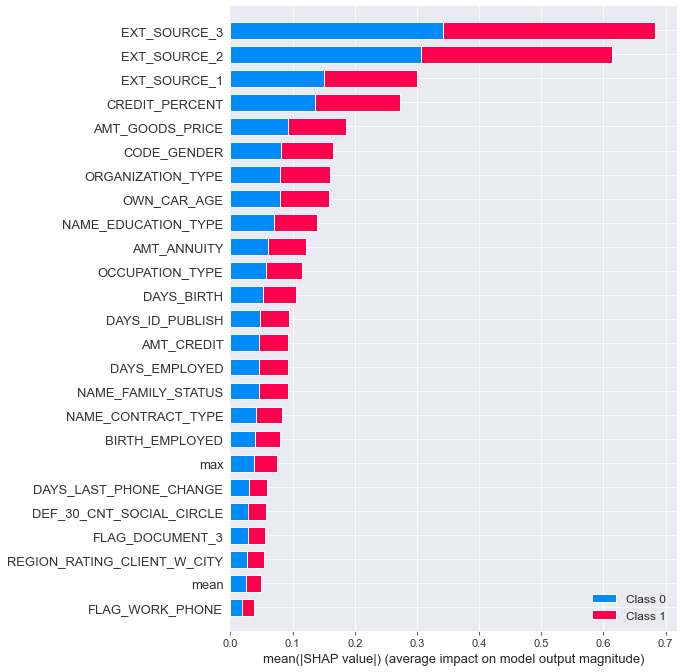

In [104]:

train_6 = train_5.merge(right=df_gr_4.reset_index(), how='left', on='SK_ID_CURR')
test_6 = test_5.merge(right=df_gr_4.reset_index(), how='left', on='SK_ID_CURR')
train_b, test_b = train_6.align(train_6, join='inner', axis=1)

cat = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
       'EMERGENCYSTATE_MODE']
for c in cat:
    train_b[c] = train_b[c].astype('category')

for c in cat:
    test_b[c] = test_b[c].astype('category')

model_5 = LGBMClassifier(objective="binary")
model_5.fit(train_b, target_3, categorical_feature=cat)
predict_5 = model_5.predict_proba(test_b)[:, 1]
metrics_5 = roc_auc_score(target_3, predict_5)
print('LightGBM: ROC AUC=%.3f' % (metrics_5))
shap_test_3 = shap.TreeExplainer(model_5).shap_values(train_b)
shap.summary_plot(shap_test_3, test_b,
                  max_display=25, auto_size_plot=True)
